# Decision trees

Are non-parametric algorithms that carve the feature space according to one feature at a time, e.g.: 

$$ \begin{cases} 
      \text{left branch} & price \leq 2 \\
      \text{right branch} & price \gt 2 \\
   \end{cases}
$$

Each decision is a split that separates the data into two groups (known as nodes).  The goal is to have leaves (end nodes) that are purely one class or another.  The purity of nodes after each split can be calculated using [gini impurity, information gain, or variance reduction](https://en.wikipedia.org/wiki/Decision_tree_learning#Metrics).

### Pros
- easy to interpret, as they form a set of "rules"
- handle feature interactions and nonlinearity effortlessly

### Cons
- can be highly unstable with new data, meaning the tree structure can change drastically.  The solution here is to use an ensemble method like Random Forest
- decision boundaries used to carve the feature space are dependent on only one feature at a time.  This means that a perfect linear interaction between features can only be approximated with a series of zig-zagging decision boundaries.
- data are fragmented in the leaf nodes, so it may be difficult to learn common themes amongst all leaves of the same class.

In [13]:
import pandas as pd
from sklearn import tree
import numpy as np
from sklearn.feature_extraction import DictVectorizer
import sys
%pylab inline

/Users/nromano/RadiumOne/Python/MLsandbox/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


/Users/nromano/RadiumOne/Python/MLsandbox/venv/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Create train, test

In [14]:
df = pd.read_csv('../data/sample_data_cleaned.csv', sep=',', header=0, index_col=0)
feature_cols = ['adv_vertical', 'goal', 'price', 'avg_bid', 'max_bid', 'win_rate_site_table', 'win_rate_strat_table', 'hist_zscore', 'overlap']
target = 'target'

df[['adv_vertical', 'goal', 'price', 'avg_bid', 'max_bid', 'win_rate_site_table', 'win_rate_strat_table', 'hist_zscore', 'overlap', 'target']].head()

,adv_vertical,goal,price,avg_bid,max_bid,win_rate_site_table,win_rate_strat_table,hist_zscore,overlap,target
0,Travel,0.0,3.95,2.75,300.0,0.450094,0.249479,2.708366,0.001066,0
1,Travel,0.0,3.95,2.75,300.0,0.158050,0.249479,1.188635,0.000703,0
2,Travel,0.0,3.95,2.75,300.0,0.360591,0.249479,1.503285,0.000873,0
3,Travel,0.0,3.95,2.75,300.0,0.113717,0.249479,35.153628,0.004614,0
4,Travel,0.0,3.95,2.75,300.0,0.019308,0.249479,-0.091378,0.000344,0


In [15]:
#define training and testing set
df['is_train'] = np.random.uniform(0,1, len(df)) > 0.25
x_train, y_train = df[df['is_train']==True][feature_cols], df[df['is_train']==True][target]
x_test, y_test = df[df['is_train']==False][feature_cols], df[df['is_train']==False][target]

In [16]:
#vectorize the feature set and hot encode adv_vertical
vec = DictVectorizer(sparse=False)
feats_train = x_train.T.to_dict().values()
features_train = vec.fit_transform(feats_train)
feats_test = x_test.T.to_dict().values()
features_test = vec.fit_transform(feats_test)

#convert back to dataframe and check for null values
x_train = pd.DataFrame(features_train, columns = vec.get_feature_names())
x_test = pd.DataFrame(features_test, columns = vec.get_feature_names())

# Make decision tree

In [80]:
clf = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf = 15).fit(x_train, y_train)

# now find the accuracy in the testing and training set
print "test accuracy: %0.3f \n" % clf.score(x_test, y_test)
print "train accuracy: %0.3f \n" % clf.score(x_train, y_train)

# and print feature importances
print ' '.join([x[0] + ': ' + str(x[1]) + '\n' for x in zip(x_train.columns, clf.feature_importances_)])

test accuracy: 0.982 

train accuracy: 0.983 

adv_vertical=Automotive: 0.0
 adv_vertical=Finance: 0.0
 adv_vertical=Home & Garden: 0.0
 adv_vertical=Philanthropy: 0.0
 adv_vertical=Travel: 0.0
 adv_vertical=Utilities: 0.0
 avg_bid: 0.146273052758
 goal: 0.0
 hist_zscore: 0.407761617705
 max_bid: 0.0372713578849
 overlap: 0.181801638852
 price: 0.210943173707
 win_rate_site_table: 0.0
 win_rate_strat_table: 0.0159491590918



## Plot feature importances

First, zip the feature names together with their importance values and sort from highest to lowest importance

In [82]:
feat_imp_pairs = zip(x_train.columns, clf.feature_importances_)
importances = sorted(feat_imp_pairs, key=lambda x: x[1], reverse=True)
importances

[('hist_zscore', 0.40776161770545938),
 ('price', 0.2109431737071904),
 ('overlap', 0.18180163885228218),
 ('avg_bid', 0.1462730527583353),
 ('max_bid', 0.037271357884926151),
 ('win_rate_strat_table', 0.015949159091806716),
 ('adv_vertical=Automotive', 0.0),
 ('adv_vertical=Finance', 0.0),
 ('adv_vertical=Home & Garden', 0.0),
 ('adv_vertical=Philanthropy', 0.0),
 ('adv_vertical=Travel', 0.0),
 ('adv_vertical=Utilities', 0.0),
 ('goal', 0.0),
 ('win_rate_site_table', 0.0)]

#### Next, plot the importances from highest to lowest

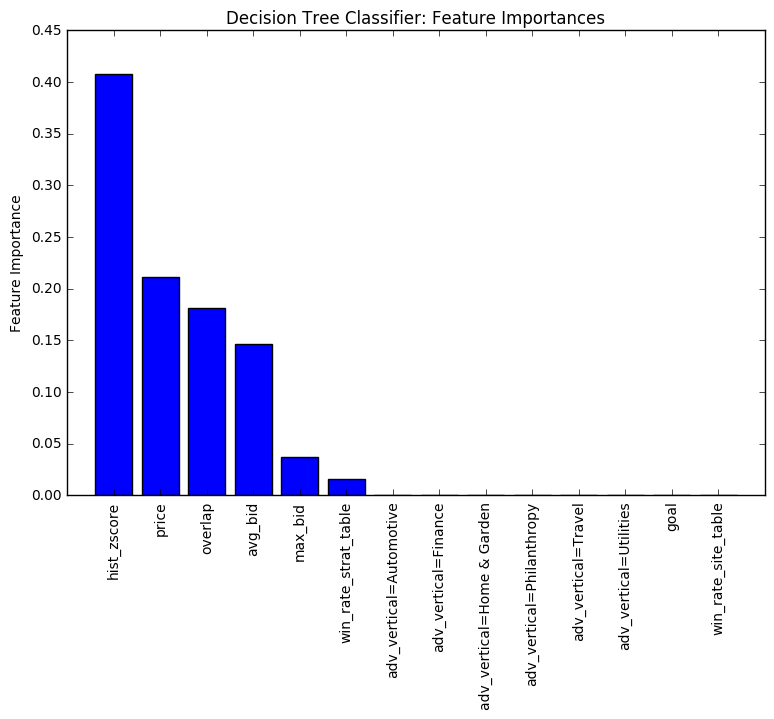

In [83]:
fig = figure(1, figsize=(9,6))
ax = fig.add_subplot(111)
bp = ax.bar(range(x_train.shape[1]), [x[1] for x in importances], align='center')
_ = plt.xticks(range(x_train.shape[1]), [x[0] for x in importances],rotation=90)
_ = plt.xlim([-1, x_train.shape[1]])
plt.ylabel('Feature Importance')
_ = plt.title('Decision Tree Classifier: Feature Importances')
plt.savefig('../figures/decision_tree_feature_importance.png')

## Draw tree

- There are documented difficulties installing pydot
- When installing this package:
   
   $ pip install .
   
   make note of where pydotplus is installed.  Add that path to your system path, as in the first line below:

In [84]:
import sys
sys.path.append('/anaconda/lib/python2.7/site-packages')
import pydotplus

#### Now proceed to draw the tree:

In [85]:
from sklearn.externals.six import StringIO

dot_data = StringIO()
tree.export_graphviz(clf, out_file = dot_data, feature_names = x_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf('../figures/draw_a_tree.pdf')

True

#### You should be able to find both visualizations in MLsandbox/MLsandbox/figures/.
